## Introduction

This tutorial will introduce you to some basic methods to construct a SMS spam classifier. To achieve this goal, you will learn how to do data preprocessing, data visulation, feature construction, machine learning model selection, training and testing. With the popularity of mobile devices, more and more SMS spams disturb people's life. Hence, to solve this problem, this tutorial guides you to implement a simple SMS spam classifier based on SMS Spam Collection Data Set from UCI Machine Learning Repository.


 

### Tutorial content

We'll be using SMS Spam Collection Data Set collected from the UCI Machine Learning Repository:https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection. 
We will cover the following topics in this tutorial:
- [Installing the libraries](#Installing-the-libraries)
- [Loading data and plotting](#Loading-data-and-plotting)
- [Text Processing](#Text-Processing)
- [Feature Construction](#Feature-Construction)
- [Model Selection,Training and Testing](#Model-Selection,-Traning-and-Testing)









## Installing the libraries

Before getting started, you'll need to install the various libraries that we will use.  You can install numpy, pandas, matplotlib, nltk, wordcloud, sklearn using 'pip':
     $ pip install --upgrade 
     $ pip install numpy
     $ pip install pandas
     $ pip install matplotlib
     $ pip install nltk
     $ pip install wordcloud
     $ pip install sklearn
if you have anaconda, you also can use:
     $ conda install -c conda-forge wordcloud 
to install wordcloud



In [95]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt 
import nltk
import string
from collections import Counter
import sklearn
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

## Loading data and plotting

Now that we've installed and loaded the libraries, let's load our SMS spam dataset. The following picture shows the SMS raw dataset and we can see two columns here, the first column is whether this SMS messages is spam or not(ham), the second column is message.

![SMS raw dataset](data.png)

Because some lines in this file has some format problems, we cannot directly load dataset as dataframe using pd.read_csv(file_path). We will use "open file" and process it line by line to inject to one dataframe. Firstly, we use open("SMSSpamCollection",'r') to open file as object; Secondly, we create a dataframe has two columns named is_spam and message; Thirdly, for every line in this file, we will use "ham" and "spam" to split, and eliminate whitespaces in the front and rear of message, then, add them to our dataframe.

In [96]:
sms_data = open("SMSSpamCollection",'r')   #open dataset as object
df = pd.DataFrame(columns=['is_spam', 'message'])    #create dataframe which has two columns 'is_spam' and 'message'
index = 0                                       
for l in sms_data.readlines():                                    
    if l[:3]=="ham": df.loc[index] = ["ham", l[3:].strip()]    #split one line using its label, and strip all whitespaces
    else: df.loc[index] = ["spam", l[4:].strip()]
    index+=1



Then, we can use df.describe() to give a description of this dataset. It shows that we have total 5574 messages in this dataset, 2 different values in column is_spam, 5160 different values in column 5160. Plus, the number of "ham" is 4827 which is larger than "spam". 

In [97]:
df.describe()

,is_spam,message
count,5574,5574
unique,2,5160
top,ham,"Sorry, I'll call later"
freq,4827,30


![SMS raw dataset](describe.png)

Also, we can use df['is_spam'].value_counts() to count the number of spam or ham in this dataset. It will return a Pandas Series which shows ham is 4827 and spam 747.

In [98]:
df['is_spam'].value_counts()

ham     4827
spam     747
Name: is_spam, dtype: int64

![SMS raw dataset](count.png)

To directy show the distribution of ham and spam, I use plt.bar to get the bar chart of distribution. Firstly, we can use index to get the number of ham and number of spam from the series we get from df['is_spam'].value_counts(); Secondly, we should compute ratio of different categories. Then, we can add title, xlabel, ylabel, category name, legend to our bar chart. Thirdly, we can add values to the top of different bars.

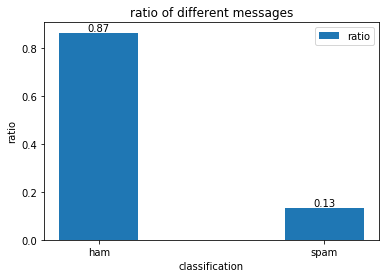

In [99]:
  
#get the number, ratio of ham and spam
ham_num = df['is_spam'].value_counts()[0]
spam_num = df['is_spam'].value_counts()[1]
ham_num_ratio = ham_num / (ham_num + spam_num) * 1.0
spam_num_ratio = spam_num / (ham_num + spam_num) * 1.0

#draw a bar chart to indicate the distribution of different catogories

#draw the time, the x label, y label
plt.title("ratio of different messages")
plt.xlabel("classification")
plt.ylabel("ratio")

#add name to different categories
plt.xticks((0,1), ('ham','spam'))

#draw bars according to the value of ratio of different categories, and set width of bars and make sure it is center-aligned
bars = plt.bar(x = (0,1),height = (ham_num_ratio,spam_num_ratio),width = 0.35,align="center")

#add legend to this bar chart
plt.legend((bars,),(u"ratio",))

#for every bar add value on top of each
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, "%.2f" % height,
            ha='center', va='bottom')

plt.show()

![SMS raw dataset](distribution.png)

## Text Processing

first, we should download some corpora manually first, For example, "stopwords", "wordnet", "punkt" using nltk.download. 

In [100]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/bowentan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/bowentan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/bowentan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Then we should do processing on every message which has a simlar rule we have built in our homework. Firstly, we should make sure every token in message is lower case; Secondly, eliminate all 's; Thirdly, eliminate all ' after the seconde operation; Fourthly, we should replace all punctuations with whitespaces; Fifthly, we should tokenize words in one message. Sixthly, we should lemmatize token to reduce dimensions and redundancy of tokens.

In [101]:
def process(message, lemmatizer=nltk.stem.wordnet.WordNetLemmatizer()):
    message = message.lower()                          #1. transfer all tokens to lower case
    message = message.replace("'s", "")                #2. replace all "'s" with ""
    message = message.replace("'", "")                 #3. replace all "'" with ""
    for p in string.punctuation:                  
        message = message.replace(p, " ")              #4. eliminate all punctuations
    res = []
    word_list = nltk.word_tokenize(message)            #5. tokenize message to reduce dimensions and redundancy
    for word in word_list:
        try:
            word = lemmatizer.lemmatize(word)          #6. lemmatize all words
            res.append(word)
        except e:
            pass
    return res

After we construct this process function on one message, we should apply this function to all messages in this dataframe to prepare for the feature construction part.

In [102]:
def process_all(df, lemmatizer=nltk.stem.wordnet.WordNetLemmatizer()):
    df['message'] = df['message'].apply(lambda x:process(x))
    return df

df = process_all(df, lemmatizer=nltk.stem.wordnet.WordNetLemmatizer())

## Feature Construction

As we did in homework before, for this time, we are going to construct a bag-of-words TF-IDF feature vector. And the first thing we should do is to omit all common words, which are stopwords that offer meaningless information. Meanwhile, we also should omit all rare words, which are words that doesn't happen more than once. The get_rare_words function as follow is to use Counter function to get the frequency of every word in all messages and we select those words of which the number is one.

In [103]:
def get_rare_words(df):
    size = df.shape[0]
    rare_word_lst = []
    for i in range(size):
        rare_word_lst.extend(df.message[i])                         
    rare_word_dict = Counter(rare_word_lst)
    res = [key for key, val in rare_word_dict.items() if val == 1]
    return sorted(res)

rare_words = get_rare_words(df)    

Then, we will use sklearn.feature_extraction.text.TfidfVectorizer to construct a sparse matrix of features for each message. The first thing we should do is to combine all stopwords and all rare_words to construct a word list to omit. The second thing is to construct sparse matrix that omits that word list.

Plus, during this process, we also return two word lists including ham_clean_text_lst, spam_clean_text_lst. They respectively represent a list consisting of all words that omit stopwords and rarewords belong to ham, a list consisting of all words that omit stopwords and rarewords belong to spam. 

In [104]:
def create_features(df, rare_words):
    
    stopwords = nltk.corpus.stopwords.words('english')  # stopwords to omit
    meaningless_words = stopwords + rare_words          # allwords including stopwords and rarewords to omit
    size = df.shape[0]
    text_lst = []                                       # a list consisting of all words
    clean_text_lst = []                                 # a list consisting of all words that omit stopwords and rarewords
    ham_clean_text_lst = []                             # a list consisting of all words that omit stopwords and rarewords that belong to ham
    spam_clean_text_lst = []                            # a list consisting of all words that omit stopwords and rarewords that belong to spam
    for i in range(size):
        text_lst.append(" ".join(df.message[i]))
        if df['is_spam'][i] == "ham":
            for word in df.message[i]:
                if word not in meaningless_words:
                    clean_text_lst.append(word)
                    ham_clean_text_lst.append(word)
        else:
            for word in df.message[i]:
                if word not in meaningless_words:
                    clean_text_lst.append(word)
                    spam_clean_text_lst.append(word)          
            
                
    tfid = sklearn.feature_extraction.text.TfidfVectorizer(stop_words = meaningless_words)
    csr = tfid.fit_transform(text_lst)
    return tfid, csr, text_lst, clean_text_lst, ham_clean_text_lst, spam_clean_text_lst


(tfidf, X, text_lst, clean_text_lst, ham_clean_text_lst, spam_clean_text_lst) = create_features(df, rare_words)




Then we use wordcloud to visualize those two list of words to see frequency of words in spam messages and frequency of words in ham messages. The first is ham wordcloud, the second is spam wordcloud, we can directly see the big difference between two types of message. For spam wordcloud, the frequency of "free", "call", "text" is very high. For example, in real world, many SMS messages are advertisements, they use "free" to capture users' eyes, hence, this result is reasonable. For ham wordcloud, most of frequent words are some words that do not have much meaning.

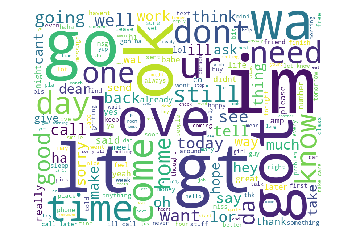

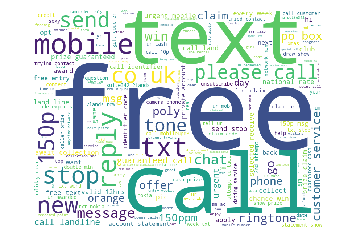

In [105]:
def get_word_cloud(text_lst):
    wordcloud = WordCloud(background_color="white",width=800, height=600, margin=2).generate(" ".join(text_lst))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

get_word_cloud(ham_clean_text_lst)
get_word_cloud(spam_clean_text_lst)

![SMS raw dataset](ham.png)
![SMS raw dataset](spam.png)

Then, we should transfer "ham" and "spam" labels to numerical value to help us train machine learning models. Hence, we get the nparray of y labels by setting all "ham" 0 and all "spam" 1

In [106]:
def create_labels(df):
    size = df.shape[0]
    res = [0 if df['is_spam'][i] == "ham" else 1 for i in range(size) ]
    return np.array(res)
y = create_labels(df)



## Model Selection, Training and Testing



Before, we train with different machine learning algorithms, we should split dataset into training dataset and testing dataset. Meanwhile, we also should split training dataset to features X_train, and labels y_train, this is the same for test dataset. 


In this part, for different machine learning algorithms, we include model selection process, model training and model testing. For model selection process, it is to select suitable hyperparameter for our machine learning models. For example, for KNN algorithm, we select the number of neighbors which is k to determine the label, for svm algorithm, we choose kernel function to determine which is better.

In [107]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### SVM Classification

First, we try SVM classification algorithm on our dataset. To do model selection, we will choose two hyperparameter of models, the first is kernel function, the second is penalty parameter C of the error term. To achieve the goal of selection, we can use 10-fold cross validation method on our training dataset using cross_val_score. It will return 10 evaluation results on 10 different validation data, we can get the average of these results to detemine whether the choice of this hyperparameter is good enough for us to train. Also, this method can help people to avoid overfitting.

For example, we set kernel function of our SVM classification algorithm to 'linear', and we iterate though 1 to 10 to select a good C for our algorithm. And we can print all mean value of cross validation for each C. Although the value is similar to each other in our case, we can choose the C which has higher mean score(when C equals 2 in this case) to train our models.



In [108]:
cross_score = []
for c in range(1,11):
    clf = svm.SVC(kernel='linear', C=c)
    scores = cross_val_score(clf, X_train, y_train, cv=10)
    print(np.mean(scores))
    cross_score.append(np.mean(scores))

0.983858461301
0.986547042369
0.986097604166
0.985425460026
0.984527589077
0.983853935628
0.98407714542
0.984301864521
0.984301864521
0.983853431773


![SMS raw dataset](scores.png)

The following code is to help us choose the highest performance C and use this C and our linear kernel function to train our model, then we use this model to do prediction on our testing dataset and we get the performance result of our training model.

In [109]:
C = cross_score.index(max(cross_score)) + 1
clf = svm.SVC(kernel='linear', C=C)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)


0.97937219730941705

The output here is 0.98206278026905824

The following code do similarly things, we set our kernel function to 'rbf', 'poly', 'sigmoid' and iterate though different values of C to determine a better C to train. Finally, we get the performance of our models on testing dataset.

In [110]:
cross_score = []
for c in range(1,11):
    clf = svm.SVC(kernel='rbf', C=c)
    scores = cross_val_score(clf, X_train, y_train, cv=10)
    cross_score.append(np.mean(scores))

In [111]:
C = cross_score.index(max(cross_score)) + 1
clf = svm.SVC(kernel='rbf', C=C)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.8618834080717489

The output here is 0.86008968609865466

In [112]:
cross_score = []
for c in range(1,11):
    clf = svm.SVC(kernel='poly', C=c)
    scores = cross_val_score(clf, X_train, y_train, cv=10)
    print(scores)
    cross_score.append(np.mean(scores))

[ 0.86577181  0.86577181  0.86577181  0.867713    0.867713    0.867713
  0.86741573  0.86741573  0.86741573  0.86741573]
[ 0.86577181  0.86577181  0.86577181  0.867713    0.867713    0.867713
  0.86741573  0.86741573  0.86741573  0.86741573]
[ 0.86577181  0.86577181  0.86577181  0.867713    0.867713    0.867713
  0.86741573  0.86741573  0.86741573  0.86741573]
[ 0.86577181  0.86577181  0.86577181  0.867713    0.867713    0.867713
  0.86741573  0.86741573  0.86741573  0.86741573]
[ 0.86577181  0.86577181  0.86577181  0.867713    0.867713    0.867713
  0.86741573  0.86741573  0.86741573  0.86741573]
[ 0.86577181  0.86577181  0.86577181  0.867713    0.867713    0.867713
  0.86741573  0.86741573  0.86741573  0.86741573]
[ 0.86577181  0.86577181  0.86577181  0.867713    0.867713    0.867713
  0.86741573  0.86741573  0.86741573  0.86741573]
[ 0.86577181  0.86577181  0.86577181  0.867713    0.867713    0.867713
  0.86741573  0.86741573  0.86741573  0.86741573]
[ 0.86577181  0.86577181  0.8657

In [113]:
C = cross_score.index(max(cross_score)) + 1
clf = svm.SVC(kernel='poly', C=C)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.8618834080717489

The output here is 0.86008968609865466

In [114]:
cross_score = []
for c in range(1,11):
    clf = svm.SVC(kernel='sigmoid', C=c)
    scores = cross_val_score(clf, X_train, y_train, cv=10)
    cross_score.append(np.mean(scores))

In [115]:
C = cross_score.index(max(cross_score)) + 1
clf = svm.SVC(kernel='sigmoid', C=C)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.8618834080717489

The output here is 0.86008968609865466

### KNN
For knn algorithm, we choose different k and weights as our hyperparameter to do model selection. Similarly, we set k from 1 to 100 and weights to 'uniform' or 'distance' to see the cross validation performance.

In [116]:

cross_score = []
for k in range(1,100):
    clf = KNeighborsClassifier(n_neighbors=k , weights='uniform')
    scores = cross_val_score(clf, X_train, y_train, cv=10)
    cross_score.append(np.mean(scores))

In [117]:
k = cross_score.index(max(cross_score)) + 1
clf = KNeighborsClassifier(n_neighbors=k , weights='uniform')
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.95156950672645735

The output here is 0.94618834080717484

In [118]:
from sklearn.neighbors import KNeighborsClassifier
cross_score = []
for k in range(1,100):
    clf = KNeighborsClassifier(n_neighbors=k , weights='distance')
    scores = cross_val_score(clf, X_train, y_train, cv=10)
    cross_score.append(np.mean(scores))

In [119]:
k = cross_score.index(max(cross_score)) + 1
clf = KNeighborsClassifier(n_neighbors=k , weights='distance')
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.95156950672645735

The output here is 0.94618834080717484

### Decision Tree
For decisiontree, we set our splitting criterion to 'gini' or 'entropy', and we change our max depth of tree do the model selection. After training the chosen model, we get performance on testing data.

In [120]:

from sklearn.tree import DecisionTreeClassifier

cross_score = []
for d in range(1,100):
    clf = DecisionTreeClassifier(criterion='gini', max_depth=d)
    scores = cross_val_score(clf, X_train, y_train, cv=10)  
    cross_score.append(np.mean(scores))


When we print the out come of score, we found when depth is 25, it doesn't change a lot, so we choose the depth equals 25

In [121]:
clf = DecisionTreeClassifier(criterion='gini', max_depth=25)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.96233183856502247

The output here is 0.97488789237668161

In [122]:
from sklearn.tree import DecisionTreeClassifier
cross_score = []
for d in range(1,100):
    clf = DecisionTreeClassifier(criterion='entropy', max_depth=d)
    scores = cross_val_score(clf, X_train, y_train, cv=10)
    cross_score.append(np.mean(scores))


When we print the out come of score, we found when depth is 15, it doesn't change a lot, so we choose the depth equals 25

In [ ]:
clf = DecisionTreeClassifier(criterion='entropy', max_depth=15)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.95964125560538116

The output here is 0.9668161434977578

### Random Forest
We also introduce the ensembled algorithm random forest to construct classifier, after iterate though different number of trees, when the score of cross validation doesn't change much, we set the number of trees to this number. For example, we found when the number of trees is 15, the score dosn't change much, we set n_estimators to 15.

In [ ]:
cross_score = []
for n in range(1,100):
    clf = RandomForestClassifier(n_estimators=n)
    scores = cross_val_score(clf, X_train, y_train, cv=10)
    print(np.mean(scores))
    
    cross_score.append(np.mean(scores))

0.951111860318
0.952240480842
0.969953546194
0.968607240242
0.97354251523
0.969058684845
0.975338751967
0.973093079282
0.978698982338
0.975333731457
0.978021307071
0.97779759117
0.978476274146
0.976907262256
0.978249047044
0.976455311545
0.977799100479
0.977129468848
0.978247029372
0.978248032572
0.979596347179
0.977575883924
0.981390073661
0.976456317
0.978472250073
0.979822575589
0.98049321042
0.979821064026
0.980263464046
0.979596848779
0.980267987464
0.97959433627
0.979142889413
0.981163845251
0.980267994227
0.977580411851
0.979594334015
0.979816538353
0.980714910903
0.980044777672
0.979366094696
0.979596848779
0.981386553443
0.979145901268
0.980264977864
0.980941141567
0.981163847505
0.978252560499
0.978698473975
0.978699987793
0.980490191802
0.979145401922
0.980040755854
0.97892319533
0.980491197256
0.980943147968
0.979371628078
0.980715414757
0.979370118769
0.980491703365
0.980042265163
0.980940637713
0.980045785381
0.980270000628
0.97959483787
0.98049371202
0.980265976555


In [ ]:
clf = RandomForestClassifier(n_estimators=15)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

The output here is 0.97937219730941705

## Summary and references
The following is the comparisons between different classifiers we have built, we can see that, performance of SVM with linear kernel, KNN and Random forest is pretty good, We can conclude that these algorithms and hyperparameters are suitable to construct our SMS SPAM classifier. 





In [ ]:

results = (0.9821,0.8601,0.8601,0.8600,0.9461,0.9461,0.9749,0.9668,0.9793)
#draw the time, the x label, y label
plt.title("performances of classifiers")
plt.xlabel("classifiers")
plt.ylabel("performances")
#add name to different categories
plt.xticks((0,1,2,3,4,5,6,7,8), ('svm-linear','svm-rbf', 'svm-poly', 'svm-sigmoid', 'knn-distance','knn-uniform', 'DT-gini', 'DT-entropy', 'RF'),rotation=20)
#draw bars according to the value of ratio of different categories, and set width of bars and make sure it is center-aligned
bars = plt.bar(x = (0,1,2,3,4,5,6,7,8),height = results,width = 0.8,align="center", linewidth="5")

# #add legend to this bar chart
# plt.legend((bars,),(u"ratio",))

#for every bar add value on top of each
# for bar in bars:
#     height = bar.get_height()
#     plt.text(bar.get_x() + bar.get_width() / 2, height, "%.2f" % height,
#             ha='center', va='bottom')

plt.show()

![SMS raw dataset](results.png)

In this tutorial, we have included the whole process to construct a SMS SPAM classifier including analyzing and visualizing data, doing text preprocessing, contructing features, selecting models, training models and measuring models. If you are interested in some libraries, methods, models we use, you can refer to the following links.




    WordCloud: https://amueller.github.io/word_cloud/
    KNN: http://scikit-learn.org/stable/modules/neighbors.html
    SVM: http://scikit-learn.org/stable/modules/svm.html
    Decision Tree: http://scikit-learn.org/stable/modules/tree.html
    Random Forest: http://scikit-learn.org/stable/modules/ensemble.html#forests-of-randomized-trees
    NLTK: https://www.nltk.org/
